# Lognormally Distributed Stock Prices

In [6]:
import numpy as np
from scipy.sparse import diags, linalg
import matplotlib.pyplot as plt
from scipy.linalg import solve_banded
from time import time
from scipy.stats import norm, lognorm

%matplotlib inline

### Notation

$S_0 = \mbox{Initial Stock Price}$<br>
$S = \mbox{Stock Price}$<br>
$\sigma = \mbox{Implied Volatility}$<br>
$r = \mbox{Risk-free Rate}$<br>
$t = \mbox{Time}$<br>

We will use our Monte Carlo code to generate a large number of simulated stock runs.  The log-normal distribution is:

## $$f(S) = \frac{1}{S \sigma \sqrt{2\pi t}} e^{ \frac{-\left(\ln(S) - \ln(S_0) - \left[r - \frac{\sigma^2}{2}\right] \right)^2}{2 \sigma^2 t}}  $$

Below is our Monte Carlo code to model stock price action.  We will simulate a large number of stock runs, then compare how well the final distribution is reflected by the lognormal.

In [7]:
#  Reset the random seed
np.random.seed(2)

#  Numer of simulations
N_sims = 100000

#  Stock information
S0 = 100.0
r = 0.01 / 252 # 252 trading days
dt = 1.0
sigma = 0.75 / np.sqrt(252)

#  Number of days per simulation
N_days = 30

#  Create an array of random numbers, then delete the first element
epsilon = np.random.normal(  size = (N_sims * N_days + N_sims) )
epsilon = np.delete(epsilon, 0)

![Image](https://slidetodoc.com/presentation_image/ba4f7abf1e222521fa9bb59f94db32f7/image-10.jpg)

In [ ]:
#  Create ds_s 
ds_s = r * dt + sigma * np.sqrt(dt) * epsilon # percent change in the stock price
ds_s[N_days:N_days * N_sims + N_sims:N_days+1] = -1

ones = -np.ones((N_sims * N_days + N_sims))
ones[0:-1:N_days+1] = 1

M = diags( [ds_s + 1, ones], [-1, 0], format = 'csc')

Y = np.zeros( (N_sims * N_days + N_sims) )
Y[0:-1:N_days + 1] = S0

X = linalg.spsolve(M, Y)

X = np.reshape(X, (N_sims, N_days+1))

#rows, cols = X.shape
#if rows <= 11:
#    for i in range(N_sims):
#        plt.plot(X[i,:])
#
#    print(X.shape)
#    plt.grid(True)
#    plt.xlabel('Day')
#    plt.ylabel('Stock Price')

There are built-in functions in Scipy to deal with the density and cummulative distributions, but we can code it by hand to make sure we understand the inputs.

In [8]:
def lognormal(x, sigmga, r, t, S0 = 100):
    exp_num = -(np.log(x) - np.log(S0) - (r - sigma**2 / 2) * t)**2
    exp_dem = 2 * sigma**2 * t
    
    exp_term = np.exp(exp_num / exp_dem)
    prefactor = 1 / (x * sigma * np.sqrt(2 * np.pi * t))
    
    return np.multiply(prefactor, exp_term)

Text(0, 0.5, 'Density Function')

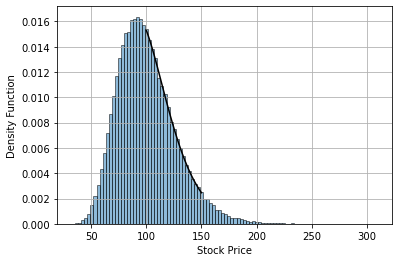

In [9]:
#  Get our prices from the Monte Carlo simulation.  We need all rows of the last column.  These are the prices for all runs on the final day of the simulation.
prices = X[:, -1]

#  Parameters.  Time, risk-free rate, and volatility
t = 30 / 252
r = 0.01
sigma = 0.75

#  Generate a range of prices to plot our function
x = np.linspace(100, 150, 100)
#x = np.linspace(40, 200, 100)
f = lognormal(x, sigma, r, t, S0 = 100)

#  Plot a histrogram of our Monte Carlo prices
N, bins, pachtes = plt.hist(prices, bins = 100, ec = 'k', density = True, alpha = 0.5)

#  Overlay our lognormal
plt.plot(x, f, 'k')
plt.grid(True)
plt.xlabel('Stock Price')
plt.ylabel('Density Function')

In [10]:
#  What is the probability of being in the range defined above?  First we will use trapz
prob_trapz = np.trapz(f, x); print(prob_trapz) #Integrate along the given axis using the composite trapezoidal rule

#  Calculate the mean and std to use in  in the Scipy cdf
std = sigma * np.sqrt(t)
mean = np.log(S0) + (r - sigma**2 / 2) * t

#  The probability is the difference between the cummulative distribution evaluated at our points of interest
p1 = lognorm.cdf(x[0], std, loc = 0, scale = np.exp(mean))
p2 = lognorm.cdf(x[-1], std, loc = 0, scale = np.exp(mean))
print(p2 - p1)

0.40499225430003954
0.40499005936311505
